<a href="https://colab.research.google.com/github/fengtastics/111-Capstone/blob/master/Arterra_Project_HoltWinter_BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Online resources



In [1]:
#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3

#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

#https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

#HOLT Winter & ARIMA
#https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/
#https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873
#https://medium.com/data-science-in-your-pocket/starting-off-with-time-series-56056c4f4b78



#https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
from numpy import log
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib

from fbprophet import Prophet


# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.graphics.api import qqplot


matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'

In [3]:
#raw_df = pd.read_csv("C:\\Users\\mcinn\\Documents\\timeseries_vqa.csv")
raw_df = pd.read_csv("timeseries_fixeddate.csv",encoding='latin-1')   
#raw_df = pd.read_csv("timeseries_fixeddate.csv")     
   
raw_df.head()
#raw_df.info()

,ï»¿Region,Actual Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,9L Cases
0,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1
1,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0
2,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0
3,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8
4,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13


In [4]:
# replace Sales Dollar , 9L Cases to NUMBERS format

raw_df['9L Cases'] = raw_df['9L Cases'].str.replace(',', '').astype(float)
raw_df.head()



,ï»¿Region,Actual Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,9L Cases
0,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1.0
1,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0.0
2,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0.0
3,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8.0
4,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13.0


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211587 entries, 0 to 211586
Data columns (total 11 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ï»¿Region                   211587 non-null  object 
 1   Actual Date                 211587 non-null  object 
 2   AWC Fiscal Year Month Abbr  211587 non-null  object 
 3   AWC FYr & Pd No             211587 non-null  int64  
 4   Country Group               211587 non-null  object 
 5   AWC and Comp                211587 non-null  object 
 6   Varietal                    211567 non-null  object 
 7   Brand                       211587 non-null  object 
 8   Channel                     211587 non-null  object 
 9   Unit Size                   211587 non-null  int64  
 10  9L Cases                    211587 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 17.8+ MB


In [6]:
raw_df = raw_df.rename({'Actual Date': 'Date','9L Cases':'cases','ï»¿Region':'Region'}, axis=1) 

#raw_df['Date'] = raw_df['Date'].str[1:]
raw_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
0,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1.0
1,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0.0
2,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0.0
3,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8.0
4,ONT,1/1/2021,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13.0


In [7]:
#import datetime
raw_df['Date'] = pd.to_datetime(raw_df['Date'])
raw_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
0,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,BODACIOUS,Grocery Scan,750,1.0
1,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CALETA,Grocery Scan,750,0.0
2,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,CAPE ONE,Grocery Scan,750,0.0
3,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,750,8.0
4,ONT,2021-01-01,F2021 JAN,202111,CANADA-ICB,AWC,CABERNET SAUVIGNON,JACKSON TRIGGS PROPRIETORS SEL,Grocery Scan,1500,13.0


In [8]:
raw_df['Date'].min(), raw_df['Date'].max()

(Timestamp('2016-03-01 00:00:00'), Timestamp('2021-01-01 00:00:00'))

In [9]:
raw_df['Country Group'].unique()


array(['CANADA-ICB', 'CANADA-VQA'], dtype=object)

In [10]:
raw_df['Channel'].unique()

array(['Grocery Scan', 'Regular OTC Sales', 'IND RETAILERS - SHIPMENTS',
       'BC LIQUOR STORES - OVER THE COUNTER'], dtype=object)

In [11]:

#ICB
icb_df = raw_df.loc[raw_df['Country Group'] == 'CANADA-ICB']
bc_icb_df = icb_df.loc[icb_df['Region'] == 'BC']
ont_icb_df=icb_df.loc[icb_df['Region'] == 'ONT']

#VQA
vqa_df = raw_df.loc[raw_df['Country Group'] == 'CANADA-VQA']
bc_vqa_df = vqa_df.loc[vqa_df['Region'] == 'BC']
ont_vqa_df=vqa_df.loc[vqa_df['Region'] == 'ONT']


#Channel

BC_ind_df = raw_df.loc[raw_df['Channel'] == 'IND RETAILERS - SHIPMENTS']
BC_OTC_df = raw_df.loc[raw_df['Channel'] == 'BC LIQUOR STORES - OVER THE COUNTER']

ONT_groc_df = raw_df.loc[raw_df['Channel'] == 'Grocery Scan']
ONT_OTC_df = raw_df.loc[raw_df['Channel'] == 'Regular OTC Sales']



In [12]:
#Varietal 

#BC_ind_cabsauv_4L_df = BC_ind_df[(BC_ind_df['Unit Size']=='4000') & (BC_ind_df['Varietal'] == 'CABERNET SAUVIGNON') & (BC_ind_df['Brand'] == 'JACKSON TRIGGS PROPRIETORS SEL')]
JT_4L_df = BC_ind_df[(BC_ind_df['Varietal'] == 'CABERNET SAUVIGNON') & (BC_ind_df['Brand'] == 'JACKSON TRIGGS PROPRIETORS SEL') & (BC_ind_df['Unit Size']==4000)]
JT_1500_df = BC_ind_df[(BC_ind_df['Varietal'] == 'CABERNET SAUVIGNON') & (BC_ind_df['Brand'] == 'JACKSON TRIGGS PROPRIETORS SEL') & (BC_ind_df['Unit Size']==1500)]
JT_750_df = BC_ind_df[(BC_ind_df['Varietal'] == 'CABERNET SAUVIGNON') & (BC_ind_df['Brand'] == 'JACKSON TRIGGS PROPRIETORS SEL') & (BC_ind_df['Unit Size']==750)]
open_cabmerlot_750_df = BC_ind_df[(BC_ind_df['Varietal'] == 'CABERNET MERLOT') & (BC_ind_df['Brand'] == 'OPEN') & (BC_ind_df['Unit Size']==750)]

Bodacious_df = raw_df[(raw_df['Brand'] == 'BODACIOUS') & (raw_df['Region']=='BC')]

#CHANGE  variatal df HERE!!!!
bc_icb_df = BC_ind_df



In [13]:
bc_icb_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
1157,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,KERNER,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1158,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,MERLOT,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1159,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,UNASSIGNED,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1160,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,ZWEIGELT,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1161,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,UNASSIGNED,0927363 BC LTD. - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0


In [14]:
bc_icb_df.head()

,Region,Date,AWC Fiscal Year Month Abbr,AWC FYr & Pd No,Country Group,AWC and Comp,Varietal,Brand,Channel,Unit Size,cases
1157,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,KERNER,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1158,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,MERLOT,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1159,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,UNASSIGNED,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1160,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,ZWEIGELT,0918130 B.C. LIMITED - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0
1161,BC,2020-12-01,F2021 DEC,202110,CANADA-VQA,COMPETITOR,UNASSIGNED,0927363 BC LTD. - UNASSIGNED BRAND,IND RETAILERS - SHIPMENTS,750,0.0


### TRY 1 Country group


In [15]:
bc_icb_df['Region'].unique()

array(['BC'], dtype=object)

In [16]:
bc_icb_df.isnull().sum()


Region                         0
Date                           0
AWC Fiscal Year Month Abbr     0
AWC FYr & Pd No                0
Country Group                  0
AWC and Comp                   0
Varietal                      18
Brand                          0
Channel                        0
Unit Size                      0
cases                          0
dtype: int64

##  CHANGE   DF NAME MIXEDUP  HERE!!!!!!!!! ###


In [17]:
# Test the DF you want




#bc_icb_region_cases=bc_icb_df.groupby(['Date'])['cases'].sum().reset_index()
#bc_ind_df_cases=BC_ind_df.groupby(['Date'])['cases'].sum().reset_index()
#BC_OTC_df_cases=BC_OTC_df.groupby(['Date'])['cases'].sum().reset_index()
#bc_vqa_df_cases=bc_vqa_df.groupby(['Date'])['cases'].sum().reset_index()
#bc_icb_df_cases=bc_icb_df.groupby(['Date'])['cases'].sum().reset_index()
#ONT_OTC_df_cases=ONT_OTC_df.groupby(['Date'])['cases'].sum().reset_index()

bc_icb_df=bc_icb_df.groupby(['Date'])['cases'].sum().reset_index()

# VARIATAL SPECIFC
#bc_icb_df = bc_icb_df

#Change the df name here !!!!!!
bc_icb_region_cases=bc_icb_df


bc_icb_region_cases.head()

,Date,cases
0,2017-02-01,112434.0
1,2017-03-01,105760.0
2,2017-04-01,109840.0
3,2017-05-01,127235.0
4,2017-06-01,116091.0


In [18]:
#ONT_OTC_df_cases['Date'].min(), ONT_OTC_df_cases['Date'].max()

In [19]:
#ONT_OTC_df_cases = ONT_OTC_df_cases.iloc[:-1] 

In [20]:
#Change the df name here !!!!!!
#bc_icb_region_cases=ONT_OTC_df_cases


#bc_icb_region_cases.tail()

# MODEL BEGINS HERE

In [21]:
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Differencing 

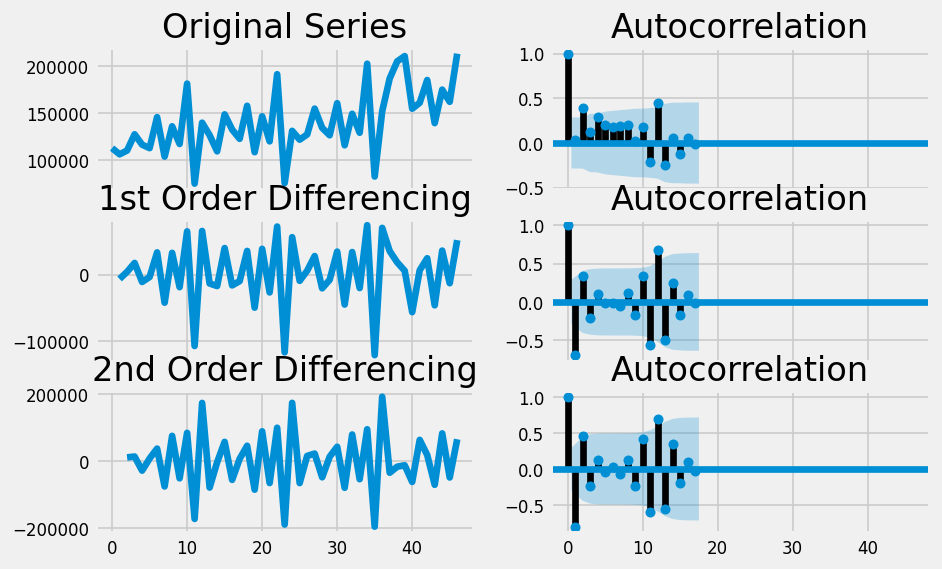

In [22]:
#
#ICB

plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(bc_icb_region_cases.cases); axes[0, 0].set_title('Original Series')
sm.graphics.tsa.plot_acf(bc_icb_region_cases.cases, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(bc_icb_region_cases.cases.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(bc_icb_region_cases.cases.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(bc_icb_region_cases.cases.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(bc_icb_region_cases.cases.diff().diff().dropna(), ax=axes[2, 1])

## we need *2nd* order differencing


plt.show()

In [23]:
##  ARMA MODEL BEGIN HERE 

In [24]:
# VQA statistics
from statsmodels.tsa.stattools import adfuller

result = adfuller(bc_icb_region_cases['cases'])

print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -2.6353911235884593
p-value: 0.08590099588961514
Critical Values:
	1%: -3.584828853223594
	5%: -2.9282991495198907
	10%: -2.6023438271604937


## FORECASTING BEGINS HERE 


In [25]:
#set index
bc_icb_region_cases_ts = bc_icb_region_cases.set_index('Date')


In [26]:
bc_icb_region_cases_ts.head()

,cases
Date,
2017-02-01,112434.0
2017-03-01,105760.0
2017-04-01,109840.0
2017-05-01,127235.0
2017-06-01,116091.0


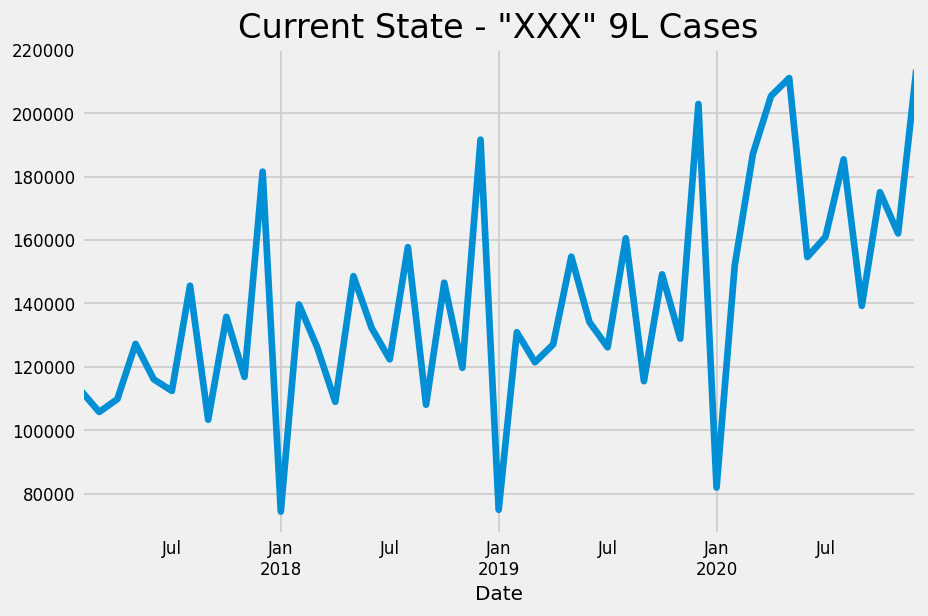

In [27]:
# plotting the original data
bc_icb_region_cases_ts['cases'].plot(title='Current State - "XXX" 9L Cases')

In [28]:
# finding shape of the dataframe
print(bc_icb_region_cases_ts.shape)


(47, 1)


In [29]:
bc_icb_region_cases_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47 entries, 2017-02-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   cases   47 non-null     float64
dtypes: float64(1)
memory usage: 752.0 bytes


In [30]:
bc_icb_region_cases_ts.head()

,cases
Date,
2017-02-01,112434.0
2017-03-01,105760.0
2017-04-01,109840.0
2017-05-01,127235.0
2017-06-01,116091.0


In [31]:
bc_icb_region_cases_ts.sort_index()
bc_icb_region_cases_ts=bc_icb_region_cases_ts.sort_index()
bc_icb_region_cases_ts.index


DatetimeIndex(['2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
               '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [32]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = bc_icb_region_cases_ts.cases[:32]  #47 records. 32 for train. 
test = bc_icb_region_cases_ts.cases[32:]

##  HOLT  WINTER

In [33]:
#https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873#

##  Decomposition ##

''

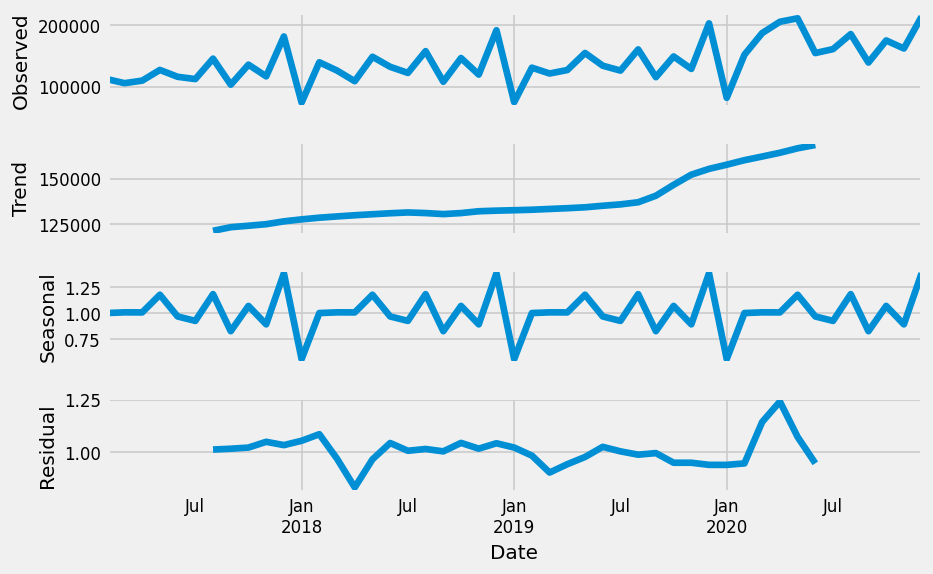

In [34]:

decompose_result = seasonal_decompose( bc_icb_region_cases_ts['cases'],model='multiplicative')
decompose_result.plot()
#plt.title('Seasonality, Trend, Residual - BC OTC')




;



In [35]:
# Set the frequency of the date time index as Monthly start as indicated by the data
bc_icb_region_cases_ts.index.freq = 'MS'
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



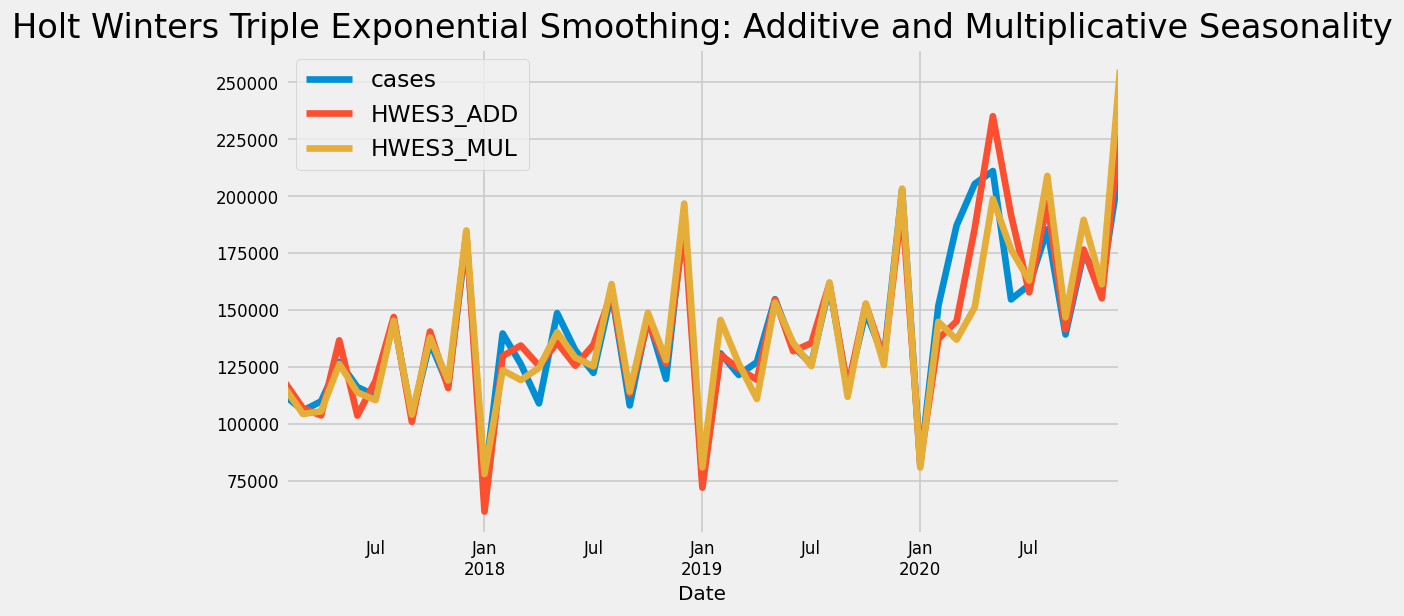

In [36]:
bc_icb_region_cases_ts['HWES3_ADD'] = ExponentialSmoothing(bc_icb_region_cases_ts['cases'],trend='add',seasonal='add',seasonal_periods=m).fit().fittedvalues
bc_icb_region_cases_ts['HWES3_MUL'] = ExponentialSmoothing(bc_icb_region_cases_ts['cases'],trend='mul',seasonal='mul',seasonal_periods=m).fit().fittedvalues
bc_icb_region_cases_ts[['cases','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

In [37]:
# Split into train and test set
train_data = bc_icb_region_cases_ts[:32]  #47 months,  32 for train, 15 for test. 
test_data = bc_icb_region_cases_ts[32:]

Text(0.5, 1.0, 'Train, Test and Prediction - BC Independent')

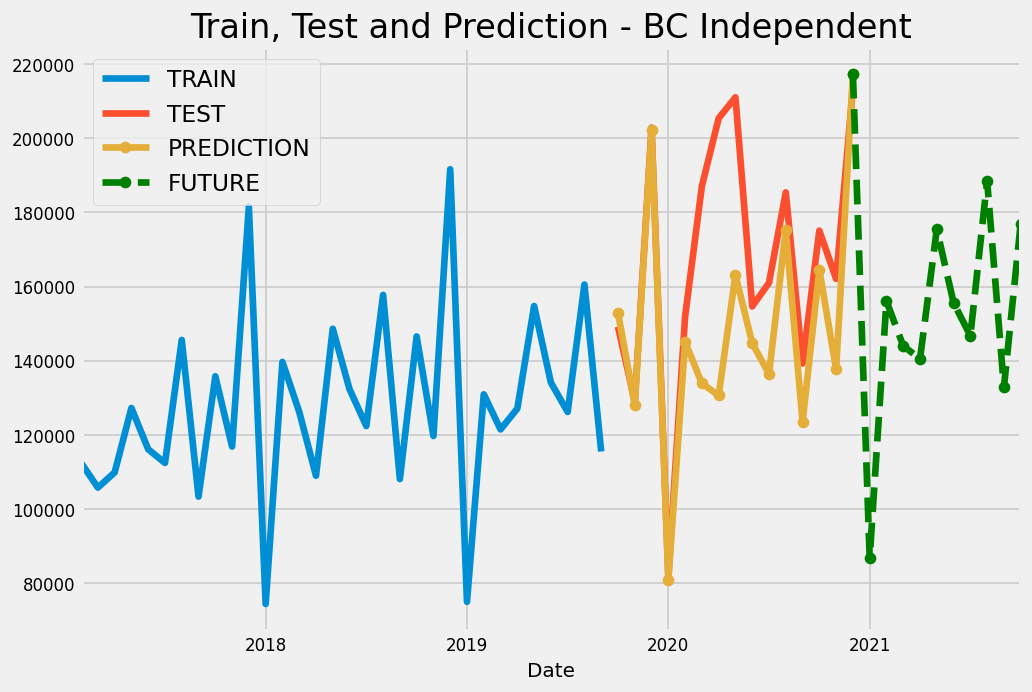

In [38]:
fitted_model = ExponentialSmoothing(train_data['cases'],trend='mul',seasonal='mul',seasonal_periods=m).fit()
all_predictions = fitted_model.forecast(25)  #15 test months + future 10 months
#future_predictions = fitted_model.forecast(20)  #15 test months + future x months
test_predictions = all_predictions[:15]  #15 for test data
future_predictions=all_predictions[14:]  #14th to 20th into the future

train_data['cases'].plot(legend=True,label='TRAIN')
test_data['cases'].plot(legend=True,label='TEST',figsize=(9,6))
test_predictions.plot(legend=True,label='PREDICTION',marker='o')
future_predictions.plot(legend=True,label='FUTURE', color='green',marker='o',style='--')


plt.title('Train, Test and Prediction - BC Independent')

In [39]:
print(test_data.shape)
print(test_predictions.shape)
test_data.tail()


(15, 3)
(15,)


,cases,HWES3_ADD,HWES3_MUL
Date,,,
2020-08-01,185422.0,197146.294178,208938.004512
2020-09-01,139236.0,141466.533528,146778.089061
2020-10-01,175098.0,176543.327489,189636.789906
2020-11-01,162079.0,155105.465853,161266.944788
2020-12-01,213694.0,230278.519188,255579.254162


In [40]:
test_predictions.tail()

2020-08-01    175285.441448
2020-09-01    123494.646467
2020-10-01    164548.574426
2020-11-01    137670.666724
2020-12-01    217419.850944
Freq: MS, dtype: float64

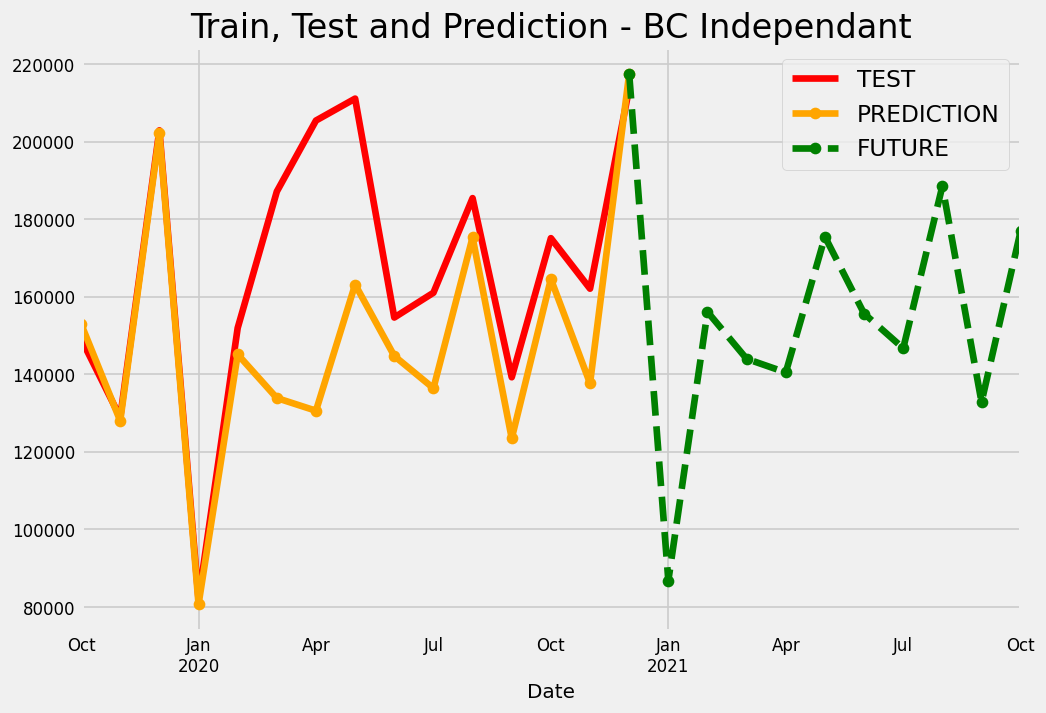

In [41]:
test_data['cases'].plot(legend=True,color='red',label='TEST',figsize=(9,6))
test_predictions.plot(legend=True,color='orange',marker='o',label='PREDICTION')
future_predictions.plot(legend=True,color='green',marker='o',style="--",label='FUTURE')
plt.title('Train, Test and Prediction - BC Independant');

In [42]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(f'Mean Absolute Error = {mean_absolute_error(test_data.cases,test_predictions)}')

print(f'Mean Squared Error = {mean_squared_error(test_data.cases,test_predictions)}')

Mean Absolute Error = 19238.012781544487
Mean Squared Error = 837950733.7225044


## Accuracy Test Summary

In [43]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(test_predictions-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [44]:
forecast_accuracy(test_data.cases,test_predictions)

{'acf1': 0.5200464781914319,
 'corr': 0.7740365512625428,
 'mae': 19238.01278154449,
 'mape': 0.13697842771737767,
 'me': 18231.918151655067,
 'minmax': 0.10557911210534221,
 'mpe': 0.13136453082939242,
 'rmse': 28947.37870209502}

#  END of CODE